In [214]:
# import neccesery libraries
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
from sentence_transformers import evaluation
import torch
import pandas as pd
from torch import nn
import numpy as np
from sentence_transformers import util
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_curve, auc, precision_score, recall_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training Phase

In [ ]:
def import_data(input_path):
  """
  Import data from csv and transform into appropriate form
  @args:
    - input_path
  @returns:
    - input_examples
  """
  # Load train and development data
  df = pd.read_csv(input_path)
  labels = df['label'].tolist()
  data_a = df['text_1'].tolist()
  data_b = df['text_2'].tolist()
  # Convert training data into input format for sentenceTransformer model
  input_examples = [InputExample(texts=[str(text1), str(text2)], label=float(label)) for text1, text2, label in zip(data_a, data_b, labels)]

  return input_examples

In [ ]:
def train_model(model_path, train_examples, eval_examples, model_name='bert', batch_size=8, loss_function='cosine'):
  """
  Train the model and save to the path
  @args:
    - model_path(str): path to save the model
    - train_examples(list[InputExample]): list of train data
    - eval_examples(list[InputExample]): list of evaluation data
    - model_name(str): choose between 'bert' and 'MiniLM'
    - batch_size(int): batch size to divide the inputs
    - loss_function(str): choose between 'cosine' or 'contrast'
  """
  if model_name == 'bert':
    # Use "bert-base-cased" for word embedding as our trainig data is case sensitive
    word_embedding_model = models.Transformer("bert-base-cased", max_seq_length=256)
    # Pooling layer
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    # Densing layer
    dense_model = models.Dense(
        in_features=pooling_model.get_sentence_embedding_dimension(),
        out_features=256,
        activation_function=nn.ReLU(),
    )
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])
  elif model_name == 'MiniLM':
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
  elif model_name == 'micro':
    word_embedding_model = models.Transformer("microsoft/deberta-base", max_seq_length=256)
    # Pooling layer
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    # Densing layer
    dense_model = models.Dense(
        in_features=pooling_model.get_sentence_embedding_dimension(),
        out_features=256,
        activation_function=nn.ReLU(),
    )
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

  train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  eval_dataloader = DataLoader(eval_examples, shuffle=False, batch_size=batch_size)

  # Loss function
  if loss_function == 'cosine':
    train_loss = losses.CosineSimilarityLoss(model=model)
  elif loss_function == 'contrast':
    train_loss = losses.ContrastiveLoss(model=model)

  # Create an evaluator with cosine similarity for more effective validation
  evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, name='dev')

  # Train the model
  model.fit(train_objectives=[(train_dataloader, train_loss)],
            evaluator=evaluator,
            epochs=3,
            evaluation_steps=500,
            warmup_steps=100)

  model.save(model_path)
  return

In [ ]:
model_path_to_save = '/content/drive/MyDrive/COMP34812/micro_model_b'
# Import data
train_examples = import_data('/content/drive/MyDrive/COMP34812/train.csv')
eval_examples = import_data('/content/drive/MyDrive/COMP34812/dev.csv')
# Train the model
train_model(model_path_to_save, train_examples, eval_examples, model_name='micro', batch_size=8, loss_function='contrast')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3750 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3750 [00:00<?, ?it/s]

# Hyperparameter tuning Phase


## Helper function defined


### Run these functions before Evaluation

In [215]:
def calculate_similarities(model, test_data_a, test_data_b):
  """
  @args:
    - model
    - test_data_a
    - test_data_b
  @return:
    - similarities
  """
  embeddings_a = model.encode(test_data_a, convert_to_tensor=True).cpu().numpy()
  embeddings_b = model.encode(test_data_b, convert_to_tensor=True).cpu().numpy()

  # Calculate cosine similarities between all pairs
  similarities = util.cos_sim(embeddings_a, embeddings_b)

  # diagonal index is what we need since each pair (i, i) is what matches
  similarities = [similarities[i, i] for i in range(len(test_data_a))]
  return similarities

In [216]:
def import_testing_data(testing_path, has_label=False):
  """
  Import testing data into two columns
  @args:
    - testing_path: The path to the CSV file containing the test data
    - has_label: A boolean indicating whether the data includes a label column
  """
  df = pd.read_csv(testing_path)
  data_a = df['text_1'].tolist()
  data_b = df['text_2'].tolist()
  if has_label:
    labels = df['label'].tolist()
    return data_a, data_b, labels
  else:
    return data_a, data_b

In [217]:
def find_optimal_threshold(similarities, actual_labels):
  # Convert lists to numpy arrays for faster processing
  similarities = np.array(similarities)
  actual_labels = np.array(actual_labels)

  # Calculate ROC curve and ROC area
  fpr, tpr, thresholds = roc_curve(actual_labels, similarities)
  roc_auc = auc(fpr, tpr)

  # Calculate the optimal threshold: the one that is closest to the top-left corner
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]

  # Return the optimal threshold and the area under the curve
  return optimal_threshold


In [218]:
def plot_score_distribution(cosine_similarities, predictions, actual_labels, model_name):
  cosine_similarities = np.array(cosine_similarities)
  predictions = np.array(predictions)
  actual_labels = np.array(actual_labels)

  # First, we will determine scores where the actual label is "same author"
  same_author_scores = cosine_similarities[actual_labels == 1]

  # Next, we will determine scores where the actual label is "different authors"
  diff_author_scores = cosine_similarities[actual_labels == 0]

  # Now we create a histogram of the scores
  plt.figure(figsize=(10, 6))
  plt.hist(same_author_scores, bins=50, alpha=0.5, label='same_author')
  plt.hist(diff_author_scores, bins=50, alpha=0.5, label='diff_author')

  # Add labels and title
  plt.xlabel('Cosine similarity')
  plt.ylabel('count')
  plt.title(f'Cosine similarity distribution of {model_name}')
  plt.legend()

  # Show the plot
  plt.show()

In [219]:
def calculate_prediction(cosine_similarities, actual_label=None, threshold=None):
  # Find the best threshold if not provided
  if not threshold:
    threshold, _= find_optimal_threshold(cosine_similarities, actual_label)
    print('optimal_threshold: ', threshold)
  predicted_labels = [1 if sim >= threshold else 0 for sim in cosine_similarities]
  if actual_label:
    accuracy = accuracy_score(actual_label, predicted_labels)
    precision = precision_score(actual_label, predicted_labels)
    recall = recall_score(actual_label, predicted_labels)
    f1 = f1_score(actual_label, predicted_labels)
    roc_auc = roc_auc_score(actual_label, cosine_similarities)

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("ROC-AUC: ", roc_auc)
  return predicted_labels

## Analysis different models

In [ ]:
# Trained model with hypterparameters:
#  - pre-trained model: 'bert-base-cased'
#  - batch size: 8
#  - loss function: cosine
bert_model_a = SentenceTransformer('/content/drive/MyDrive/COMP34812/bert_model')

In [ ]:
# Trained model with hypterparameters:
#  - pre-trained model: 'bert-base-cased'
#  - batch size: 8
#  - loss function: contrast
bert_model_b = SentenceTransformer('/content/drive/MyDrive/COMP34812/bert_model_2')

In [ ]:
# Trained model with hypterparameters:
#  - pre-trained model: 'microsoft/deberta-base'
#  - batch size: 8
#  - loss function: cosine
micro_model = SentenceTransformer('/content/drive/MyDrive/COMP34812/micro_model')

In [ ]:
# Trained model with hypterparameters:
#  - pre-trained model: 'sentence-transformers/all-MiniLM-L6-v2'
#  - batch size: 8
#  - loss function: cosine
mini_model = SentenceTransformer('/content/drive/MyDrive/COMP34812/mini_model')

In [ ]:
# Trained model with hypterparameters:
#  - pre-trained model: 'microsoft/deberta-base'
#  - batch size: 8
#  - loss function: contrast
micro_model_b = SentenceTransformer('/content/drive/MyDrive/COMP34812/micro_model_b')

In [ ]:
# Import test data
test_path = '/content/drive/MyDrive/COMP34812/dev.csv'
test_data_a, test_data_b, actual_label= import_testing_data(test_path, True)

In [ ]:
# Calculate cosine similarities on the test data on different models
berta_similarities = calculate_similarities(bert_model_a, test_data_a, test_data_b)
bertb_similarities = calculate_similarities(bert_model_b, test_data_a, test_data_b)
micro_similarities = calculate_similarities(micro_model, test_data_a, test_data_b)
mini_similarities = calculate_similarities(mini_model, test_data_a, test_data_b)
microb_similarities = calculate_similarities(micro_model_b, test_data_a, test_data_b)

In [ ]:
microb_similarities = calculate_similarities(micro_model_b, test_data_a, test_data_b)

optimal_threshold:  0.468353
Accuracy:  0.8243333333333334
Precision:  0.8286865972455492
Recall:  0.8193291265360345
F1 Score:  0.8239812959251838
ROC-AUC:  0.909965622871152


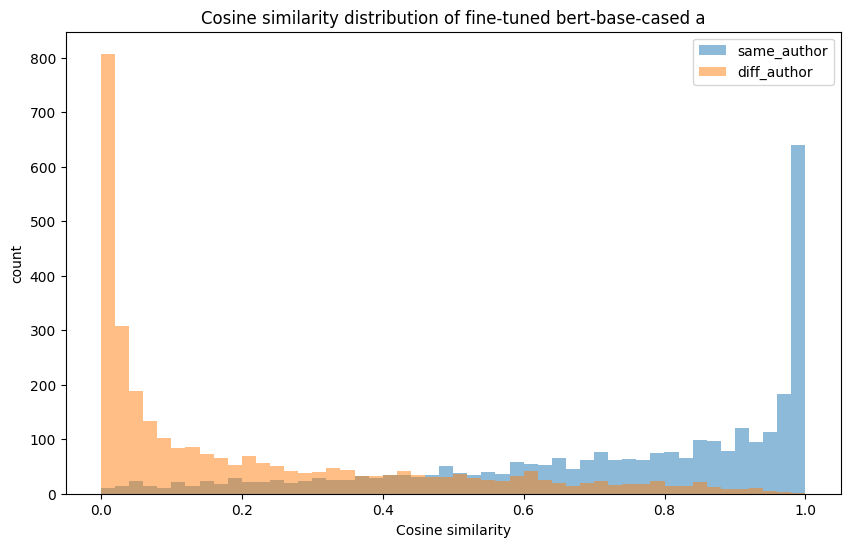

In [ ]:
predicted_labels = calculate_prediction(berta_similarities, actual_label)
plot_score_distribution(berta_similarities, predicted_labels, actual_label, 'fine-tuned bert-base-cased a')

optimal_threshold:  0.73321575
Accuracy:  0.8331666666666667
Precision:  0.8411405295315683
Recall:  0.8229823978744603
F1 Score:  0.8319623971797884
ROC-AUC:  0.9209797153939515


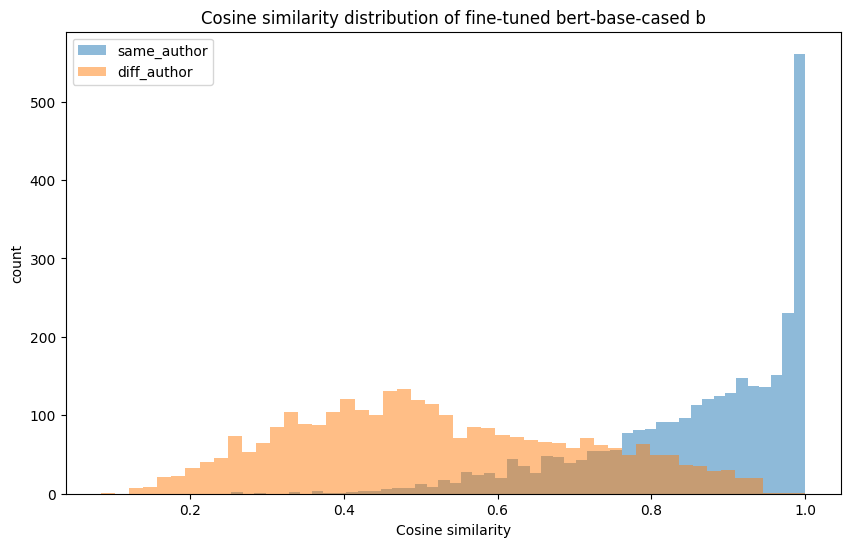

In [ ]:
predicted_labels = calculate_prediction(bertb_similarities, actual_label)
plot_score_distribution(bertb_similarities, predicted_labels, actual_label, 'fine-tuned bert-base-cased b')

optimal_threshold:  0.37720937
Accuracy:  0.8321666666666667
Precision:  0.8109869646182495
Recall:  0.8678180006642312
F1 Score:  0.8384405583186267
ROC-AUC:  0.9182090670330122


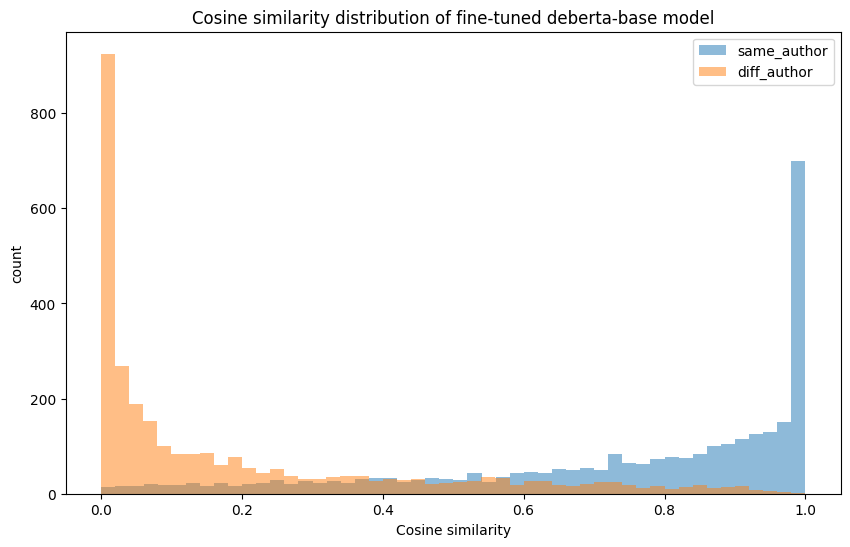

In [ ]:
predicted_labels = calculate_prediction(micro_similarities, actual_label)
plot_score_distribution(micro_similarities, predicted_labels, actual_label, 'fine-tuned deberta-base model')

optimal_threshold:  0.8704005
Accuracy:  0.5693333333333334
Precision:  0.6626047220106626
Recall:  0.28894055131185653
F1 Score:  0.4024051803885291
ROC-AUC:  0.5828351692283863


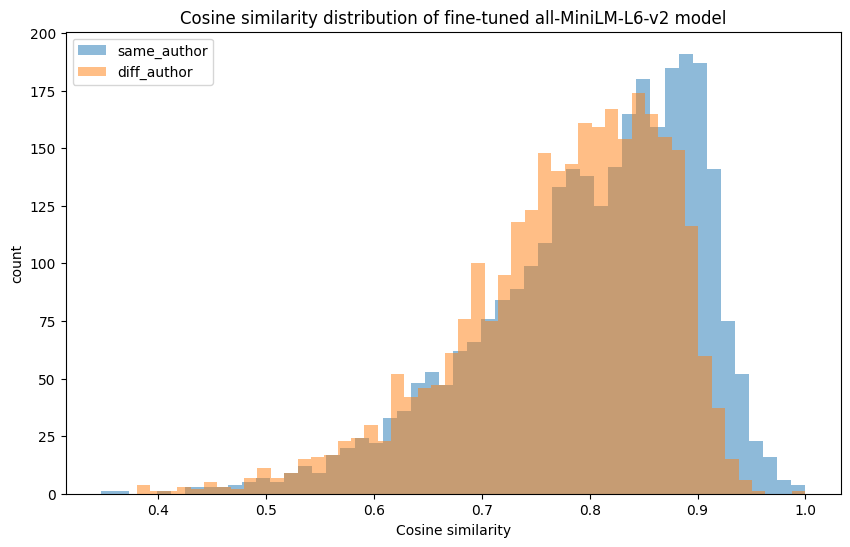

In [ ]:
predicted_labels = calculate_prediction(mini_similarities, actual_label)
plot_score_distribution(mini_similarities, predicted_labels, actual_label, 'fine-tuned all-MiniLM-L6-v2 model')

optimal_threshold:  0.7205254
Accuracy:  0.8481666666666666
Precision:  0.8384912959381045
Recall:  0.8638326137495849
F1 Score:  0.8509733355144773
ROC-AUC:  0.9325044258928372


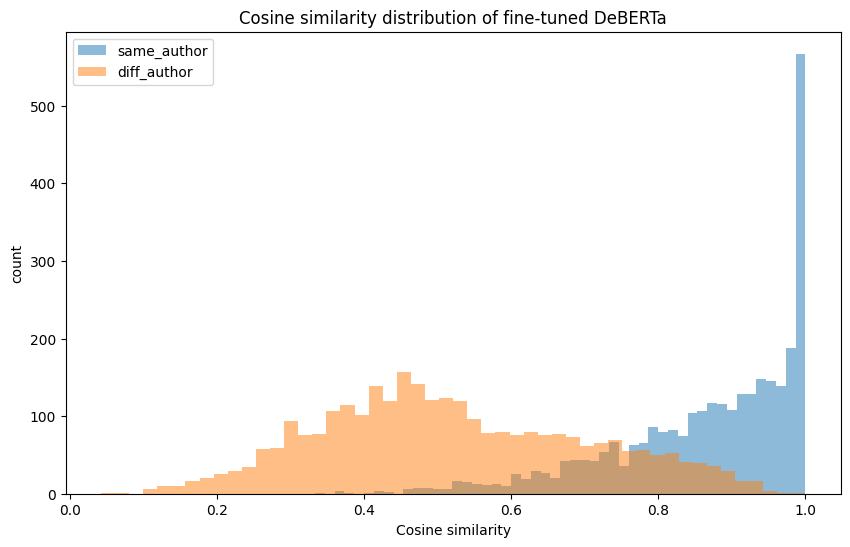

In [ ]:
predicted_labels = calculate_prediction(microb_similarities , actual_label)
plot_score_distribution(microb_similarities , predicted_labels, actual_label, 'fine-tuned DeBERTa')

# Evaluation Phase


In [ ]:
# import neccesery libraries
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
from sentence_transformers import evaluation
import torch
import pandas as pd
from torch import nn
import numpy as np
from sentence_transformers import util
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_curve, auc, precision_score, recall_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

### Run these functions before Evaluation

In [ ]:
def calculate_similarities(model, test_data_a, test_data_b):
  """
  @args:
    - model
    - test_data_a
    - test_data_b
  @return:
    - similarities
  """
  embeddings_a = model.encode(test_data_a, convert_to_tensor=True).cpu().numpy()
  embeddings_b = model.encode(test_data_b, convert_to_tensor=True).cpu().numpy()

  # Calculate cosine similarities between all pairs
  similarities = util.cos_sim(embeddings_a, embeddings_b)

  # diagonal index is what we need since each pair (i, i) is what matches
  similarities = [similarities[i, i] for i in range(len(test_data_a))]
  return similarities

In [ ]:
def import_testing_data(testing_path, has_label=False):
  """
  Import testing data into two columns
  @args:
    - testing_path: The path to the CSV file containing the test data
    - has_label: A boolean indicating whether the data includes a label column
  """
  df = pd.read_csv(testing_path)
  data_a = df['text_1'].tolist()
  data_b = df['text_2'].tolist()
  if has_label:
    labels = df['label'].tolist()
    return data_a, data_b, labels
  else:
    return data_a, data_b

In [ ]:
def find_optimal_threshold(similarities, actual_labels):
  # Convert lists to numpy arrays for faster processing
  similarities = np.array(similarities)
  actual_labels = np.array(actual_labels)

  # Calculate ROC curve and ROC area
  fpr, tpr, thresholds = roc_curve(actual_labels, similarities)
  roc_auc = auc(fpr, tpr)

  # Calculate the optimal threshold: the one that is closest to the top-left corner
  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]

  # Return the optimal threshold and the area under the curve
  return optimal_threshold


In [ ]:
def plot_score_distribution(cosine_similarities, predictions, actual_labels, model_name):
  cosine_similarities = np.array(cosine_similarities)
  predictions = np.array(predictions)
  actual_labels = np.array(actual_labels)

  # First, we will determine scores where the actual label is "same author"
  same_author_scores = cosine_similarities[actual_labels == 1]

  # Next, we will determine scores where the actual label is "different authors"
  diff_author_scores = cosine_similarities[actual_labels == 0]

  # Now we create a histogram of the scores
  plt.figure(figsize=(10, 6))
  plt.hist(same_author_scores, bins=50, alpha=0.5, label='same_author')
  plt.hist(diff_author_scores, bins=50, alpha=0.5, label='diff_author')

  # Add labels and title
  plt.xlabel('Cosine similarity')
  plt.ylabel('count')
  plt.title(f'Cosine similarity distribution of {model_name}')
  plt.legend()

  # Show the plot
  plt.show()

In [ ]:
def calculate_prediction(cosine_similarities, actual_label=None, threshold=None):
  # Find the best threshold if not provided
  if not threshold:
    threshold, _= find_optimal_threshold(cosine_similarities, actual_label)
    print('optimal_threshold: ', threshold)
  predicted_labels = [1 if sim >= threshold else 0 for sim in cosine_similarities]
  if actual_label:
    accuracy = accuracy_score(actual_label, predicted_labels)
    precision = precision_score(actual_label, predicted_labels)
    recall = recall_score(actual_label, predicted_labels)
    f1 = f1_score(actual_label, predicted_labels)
    roc_auc = roc_auc_score(actual_label, cosine_similarities)

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("ROC-AUC: ", roc_auc)
  return predicted_labels

## Demo
Based on the evalution on different model, the pre-trained **DeBERTa** model with **contrast loss function** is chosen

In [220]:
# This should be replaced by the path to your downloaded model
model_path = '/content/drive/MyDrive/COMP34812/micro_model_b'

model = SentenceTransformer(model_path)

In [221]:
# Import test data
test_path = '/content/drive/MyDrive/COMP34812/test.csv'
test_data_a, test_data_b = import_testing_data(test_path)
similarities = calculate_similarities(model, test_data_a, test_data_b)

In [222]:
prediction = calculate_prediction(similarities, actual_label=None, threshold=0.7205)

In [ ]:
predictions_df = pd.DataFrame(prediction, columns=['prediction'])

# Save the DataFrame to a CSV file
predictions_df.to_csv('Group_78_C.csv', index=False)